# Pigeon Hole Principle

**Grupo 7:**

- Luís Almeida A84180
- João Pedro Antunes A86813 

## Enunciado e Descrição do Problema

Foi nos proposta a resolução do problema Pigeon Hole Principle, cujo enunciado é o seguinte:

**O  “pigeon hole principle” (PHP) é um problema clássico da complexidade. Basicamente:**

Existem $N$ pombos  e $N-1$ poleiros de pombos. Cada pombo ocupa totalmente um poleiro. Pretende-se alocar cada pombo a um poleiro próprio.
     
  1. Provar que não existe solução do problema, usando  Z3 em 
     1. lógica proposional
     2. lógica inteira linear
    
    
  2. Analisar a complexidade de cada uma das provas em função de N de forma empírica.

## Lógica Proposicional

Podemos modelar o problema do PHP em lógica proposicional usando $N * (N-1)$ variáveis, onde a variável $x_{pb,pl}$ determina se o pombo $pb$ foi alocado ao poleiro $pl$. Temos também de adicionar as seguintes restrições:

a) A cada poleiro é alocado um só pombo

b) A cada pombo é alocado um só poleiro

c) A cada pombo é alocado um poleiro

* A restrição a) traduz-se na seguinte notação: 

>Seja $x_{i,k}$ uma correspondência entre o pombo $i$ e o poleiro $k$. Então, para todo o poleiro $k$:

$$
\bigwedge_{i=1}^{N} (x_{i,k} \rightarrow \bigwedge_{j \neq i \wedge j = 1}^{N} \neg x_{j,k})
$$

* A restrição b) traduz-se na seguinte notação:

>Seja $x_{i,k}$ uma correspondência entre o pombo $i$ e o poleiro $k$. Então, para todo o pombo $i$:

$$
\bigwedge_{k=1}^{N-1} (x_{i,k} \rightarrow \bigwedge_{j \neq k \wedge j = 1}^{N-1} \neg x_{j,k})
$$

* A restrição c) traduz-se na seguinte notação:

>Para todo o pombo $i$:

$$
\bigvee_{ k = 1}^{N-1} x_{i,k}
$$

**Traduzindo estas restrições em código e usando o z3, obtemos a seguinte resolução:**

In [8]:
from z3 import *

In [9]:
def phpLPNoOpt(n):
    varProp = {pombo : {poleiro : Bool(str(pombo)+str(poleiro)) for poleiro in range(n-1)} for pombo in range(n)}
    s = Solver()
    s.push()
    
    # A cada pombo é alocado um poleiro c)
    for pombo in varProp:
        s.add(Or(list(varProp[pombo].values())))
        s.push()
    
    # A cada pombo é alocado um só poleiro b)
    for pombo in varProp:
        for poleiro in range(n-1):
            for poleiroComp in range(n-1):
                if not poleiroComp == poleiro:
                    s.add(Implies(varProp[pombo][poleiro], Not(varProp[pombo][poleiroComp])))
                    s.push()
    
    # A cada poleiro é alocado um só pombo a)
    for poleiro in range(n-1):
        for pombo in varProp:
            for pomboComp in range(n):
                if not pomboComp == pombo:
                    s.add(Implies(varProp[pombo][poleiro], Not(varProp[pomboComp][poleiro])))
                    s.push()
    
    return s.check()

phpLPNoOpt(8)

unsat

No entanto, sabemos que a restrição a) é equivalente à seguinte restrição:

$$
\bigwedge_{i=1}^{N} (x_{i,k} \rightarrow \bigwedge_{j = i + 1}^{N} \neg x_{j,k})
$$

Assim como a restrição b) é equivalente a:

$$
\bigwedge_{k=1}^{N-1} (x_{i,k} \rightarrow \bigwedge_{j = k+1}^{N-1} \neg x_{j,k})
$$

Estas equivalências são consequências da propriedade:

$$
(p \implies \neg q)  \iff (q \implies \neg p)
$$

**Podemos então melhorar a nossa resolução tendo em conta estas novas informações:**

In [10]:
def phpLPBasicalOpt(n):
    varProp = {pombo : {poleiro : Bool(str(pombo)+str(poleiro)) for poleiro in range(n-1)} for pombo in range(n)}
    s = Solver()
    s.push()

    # A cada pombo é alocado um poleiro c)
    for pombo in varProp:
        s.add(Or(list(varProp[pombo].values())))
        s.push()
    
    # A cada pombo é alocado um só poleiro b)
    for pombo in varProp:
        for poleiro in range(n-1):
            for poleiroComp in range(poleiro+1,n-1):
                s.add(Implies(varProp[pombo][poleiro], Not(varProp[pombo][poleiroComp])))
                s.push()


    # A cada poleiro é alocado um só pombo a)
    for poleiro in range(n-1):
        for pombo in varProp:
            for pomboComp in range(pombo+1,n):
                s.add(Implies(varProp[pombo][poleiro], Not(varProp[pomboComp][poleiro])))
                s.push()

    return s.check()

phpLPBasicalOpt(8)

unsat

Como temos restrições do tipo "apenas uma váriavel pode ser verdadeira" e "pelo menos uma variável tem de ser verdadeira", uma outra forma de resolver o problema seria usando **restrições de cardinalidade**, que são inequações da seguinte forma:

$$
\sum_{i,j = 1}^{N,N-1} x_{i,j} <= k   ,   \sum_{i,j = 1}^{N,N-1} x_{i,j} >= k
$$

Onde $k$ é uma constante entre 1 e $N$. Estas inequações dizem-nos que no máximo $k$ variáveis são verdadeiras, e que no mínimo $k$ variáveis são verdadeiras, respetivamente. Ora, se considerarmos k = 1, e usando as funções Atleast() e Atmost() do z3, conseguimos implementar esta ideia na nossa solução.

In [11]:
def phpLPMoreOpt(n):
    varProp = {pombo:{poleiro:Bool(str(pombo)+str(poleiro)) for poleiro in range(n-1)} for pombo in range(n)}
    s = Solver()
    s.push()
    
    # Todos os pombos são alocados a um e um só poleiro
    for x in varProp.values():
        p = list(x.values())
        s.add(AtLeast(*p,1))
        s.add(AtMost(*p,1))
        s.push()
    
    # Todo o poleiro só pode ter um pombo
    for x in range(n-1):
        p = [varProp[z][x] for z in varProp]
        s.add(AtMost(*p,1))
        s.push()
    
    return s.check()

phpLPMoreOpt(8)

unsat

### Análise de Complexidade

Para medirmos a complexidade empírica das nossas soluções, desenvolvemos as seguintes funções utilizando o timeit para obter o gráfico dos tempos de execução de cada uma:

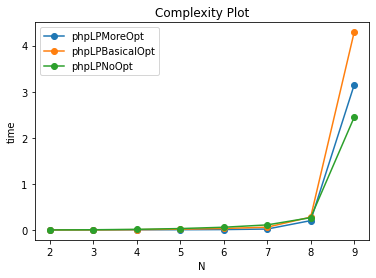

In [25]:
import matplotlib.pyplot as plt
from timeit import timeit

def timer(functNm,n,tests):
    t = timeit(setup=f"from __main__ import {functNm}", \
       stmt=f"{functNm}({n})",number=tests)/tests
    return t

def testeTmr(functNm,tests,samples):
    return [timer(functNm,n,tests) for n in samples]


def testePlot(functNm,samples):
    plt.plot(samples, testeTmr(functNm,3,samples), label= functNm, marker = "o")

def timerLP(Nmax):
    tests = range(2,Nmax)
    testePlot("phpLPMoreOpt",tests)
    testePlot("phpLPBasicalOpt",tests)
    testePlot("phpLPNoOpt",tests)
    plt.ylabel('time')
    plt.xlabel('N')
    plt.title("Complexity Plot")
    plt.legend()
    plt.show()

timerLP(10)

Observando o gráfico apresentado, podemos constatar que as 3 funções têm complexidade exponencial. De facto, mesmo com as otimizações tidas em conta, não conseguimos impedir que as nossas soluções não tenham este nível de complexidade. Esta situação deve-se ao facto de não conseguirmos limitar polinomialmente o número de monómios do polinómio que representa a função booleana do nosso problema. Assim sendo, e tendo em conta que o algoritmo de SAT tem complexidade exponencial nestes casos, seria de esperar que todas as nossas funções tivessem esta complexidade.

## Lógica Inteira Linear

Usando Lógica Inteira Linear, vamos modelar cada pombo como uma variável inteira $x_{i}$, cujo valor será o poleiro que lhe foi alocado. Temos então as seguintes restrições:

a) Todos os pombos têm um poleiro entre $1$ e $N-1$:

$$ 1 \leqslant x_{i} \leqslant N-1 $$

b) Todos os pombos têm um poleiro diferente:

$$ \forall x_{i} \quad x_{i} \neq x_{j} , \quad\forall i \neq j$$ 

Usando o z3:

In [13]:
def phpLIL(n):
    varProp = {x : Int(str(x)) for x in range(n)}
    s = Solver()
    s.push()
    
    # Todos os pombos têm um poleiro diferente b)
    for i in range(len(varProp)-1):
        s.add(varProp[i] < varProp[i+1])
            
    s.push()
    
    # Todos os pombos têm um poleiro entre 1 e N-1 a)
    for x in varProp:
        s.add(0 < varProp[x], varProp[x] <= (n-1))
        
    
    return s.check()

phpLIL(100)

unsat

Uma alternativa a esta solução, usando também Lógica Inteira Linear, seria usar $N * (N-1)$ variáveis inteiras binárias, onde a variável $x_{i,j}$ determina se foi alocado o poleiro $j$ ao pombo $i$. Esta modelação permite-nos ter enormes ganhos de eficiência, pois facilita-nos a implementação das restrições acima descritas. Vejamos como estas serão "traduzidas":

a) Todo o poleiro $j$ é alocado a um único pombo:

$$\sum_{i = 1}^{N} x_{i,j} = 1 $$

b) Todo o pombo $i$ é alocado a um único poleiro:

$$\sum_{j = 1}^{N-1} x_{i,j} = 1 $$

c) As variáveis são binárias, ou seja:

$$ \bigwedge_{i,j = 1}^{N,N-1} x_{i,j} = 1 \vee x_{i,j} = 0 $$

Posteriormente, usando o z3:

In [14]:
def phpLILBin(n):
    varProp = {}
    s = Solver()
    s.push()
    
    # As variáveis são binárias c)
    for pombo in range(n):
        varProp[pombo] = {}
        for poleiro in range(n-1):
            varProp[pombo][poleiro] = Int(str(pombo)+str(poleiro))
            s.add(Or(0 == varProp[pombo][poleiro], 1 == varProp[pombo][poleiro]))
            s.push()
    
    # Todo o pombo x é alocado a um único poleiro b)
    for x in varProp.values():
        p = list(x.values())
        s.add(Sum(p) == 1)
        s.push()
    
    # Todo o poleiro x é alocado a um único pombo a)
    for x in range(n-1):
        p = [varProp[z][x] for z in varProp]
        s.add(Sum(p) == 1)
        s.push()
    
    return s.check()

phpLILBin(20)

unsat

### Análise De Complexidade

Analisemos então a Complexidade das nossas soluções:

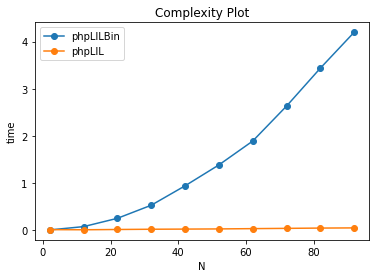

In [15]:
def timerLI(Nmax):
    tests = [x for x in range(2,Nmax,10)]
    testePlot("phpLILBin",tests)
    testePlot("phpLIL",tests)
    plt.ylabel('time')
    plt.xlabel('N')
    plt.title("Complexity Plot")
    plt.legend()
    plt.show()

timerLI(100)

Ora, comparando ambas as soluções observamos que a função que implementa lógica inteira linear sem variáveis binárias é muito mais rápida que a função que implementa esta solução, devido ao facto de ter menos variáveis, o que faz com que o número de monómios do polinómio que representa o nosso problema seja menor na função ***phpLIL***. No entanto, este gráfico é enganador pois leva-nos a crer que a função ***phpLILBin*** tem complexidade exponencial e a função ***phpLIL*** não. Observando o gráfico seguinte, constata-se que tal não é verdade: 

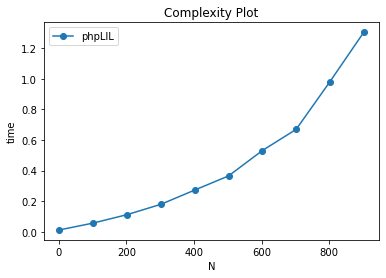

In [16]:
def timerLIL(Nmax):
    tests = [x for x in range(2,Nmax,100)]
    testePlot("phpLIL",tests)
    plt.ylabel('time')
    plt.xlabel('N')
    plt.title("Complexity Plot")
    plt.legend()
    plt.show()

timerLIL(1000)

## Versão SCIP

De seguida apresentamos funções que não são nada mais do que "traduções" para SCIP das funções implementadas anteriormente em z3:

In [17]:
from pyscipopt import Model

def phpLILscip(n):
    model = Model()
    varProp = {}
    
    for i in range(n):
        varProp[i] = model.addVar(str(i), vtype="INTEGER")
    
    for i in range(n-1):
        model.addCons(varProp[i]+1 <= varProp[i+1])
    
    for i in range(n):
        model.addCons(1 <= varProp[i])
        model.addCons(varProp[i] <= n-1)
        
    model.optimize()
    
    return model.getStatus()

phpLILscip(3000)

<ipython-input-17-e01948d1412a>:4: UserWarning: linked SCIP 7.0 is not recommended for this version of PySCIPOpt - use version 7.0.1
  model = Model()


'infeasible'

In [18]:
def phpLILscipBin(n):
    model = Model()
    varProp = {}
    
    for i in range(n):
        varProp[i] = {}
        for j in range(n-1):
            varProp[i][j] = model.addVar(str(i) + ' ' + str(j), vtype="INTEGER")
            model.addCons(0 <= varProp[i][j])
            model.addCons(varProp[i][j] <= 1)
    
    for i in range(n):
        x = list(varProp[i].values())
        model.addCons(sum(x) == 1)
    
    for x in range(n-1):
        p = [varProp[z][x] for z in varProp]
        model.addCons(sum(p) == 1)

    model.optimize()
    
    return model.getStatus()

phpLILscipBin(100)

<ipython-input-18-da342ad67639>:2: UserWarning: linked SCIP 7.0 is not recommended for this version of PySCIPOpt - use version 7.0.1
  model = Model()


'infeasible'

### Análise de Complexidade

<ipython-input-17-e01948d1412a>:4: UserWarning: linked SCIP 7.0 is not recommended for this version of PySCIPOpt - use version 7.0.1
  model = Model()
<ipython-input-18-da342ad67639>:2: UserWarning: linked SCIP 7.0 is not recommended for this version of PySCIPOpt - use version 7.0.1
  model = Model()


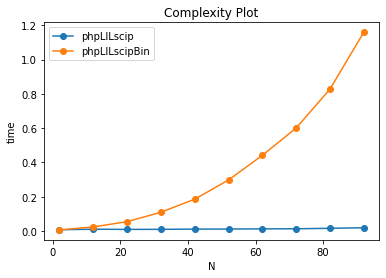

In [19]:
def timerLIscip(Nmax):
    tests = [x for x in range(2,Nmax,10)]
    testePlot("phpLILscip",tests)
    testePlot("phpLILscipBin",tests)
    plt.ylabel('time')
    plt.xlabel('N')
    plt.title("Complexity Plot")
    plt.legend()
    plt.show()

timerLIscip(100)

Observamos uma vez mais a diferença entre a velocidade de cada função e a complexidade exponencial da função ***phpLILscipBin***. Novamente, este gráfico é enganador:

<ipython-input-17-e01948d1412a>:4: UserWarning: linked SCIP 7.0 is not recommended for this version of PySCIPOpt - use version 7.0.1
  model = Model()


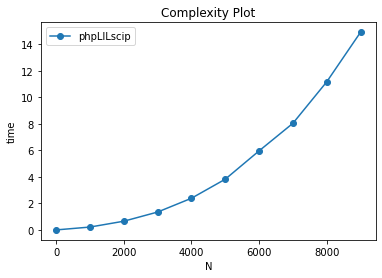

In [22]:
def timerLILscip(Nmax):
    tests = [x for x in range(2,Nmax,1000)]
    testePlot("phpLILscip",tests)
    plt.ylabel('time')
    plt.xlabel('N')
    plt.title("Complexity Plot")
    plt.legend()
    plt.show()

timerLILscip(10000)